In [59]:
# Student ID: 1010737874
# Student name: Han Zheng
# Instructor: Dr. Shion Guha
# Course code: INF2178
# Program: MI
# Faculty of Information
# University of Toronto


# Assignment 1

# connect to google colab
from google.colab import drive
drive.mount('/content/drive')

# library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# import the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/2178_homeless.xlsx'
trtHomeless = pd.read_excel(file_path)

# understand our dataset
trtHomeless.head()
trtHomeless.info()
trtHomeless.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50944 entries, 0 to 50943
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   OCCUPANCY_DATE          50944 non-null  datetime64[ns]
 1   ORGANIZATION_NAME       50944 non-null  object        
 2   PROGRAM_ID              50944 non-null  int64         
 3   PROGRAM_NAME            50909 non-null  object        
 4   SECTOR                  50944 non-null  object        
 5   PROGRAM_MODEL           50942 non-null  object        
 6   OVERNIGHT_SERVICE_TYPE  50942 non-null  object        
 7   PROGRAM_AREA            50942 non-null  object        
 8   SERVICE_USER_COUNT      50944 non-null  int64         
 9   CAPACITY_TYPE           50944 non-null  object        
 10  CAPACITY_ACTUAL_BED     32399 non-null  float64       
 11  OCCUPIED_BEDS           32399 non-null  float64       
 12  CAPACITY_ACTUAL_ROOM    18545 non-null  float6

,PROGRAM_ID,SERVICE_USER_COUNT,CAPACITY_ACTUAL_BED,OCCUPIED_BEDS,CAPACITY_ACTUAL_ROOM,OCCUPIED_ROOMS
count,50944.000000,50944.000000,32399.000000,32399.000000,18545.000000,18545.000000
mean,13986.125844,45.727171,31.627149,29.780271,55.549259,52.798598
std,1705.288632,53.326049,27.127682,26.379416,59.448805,58.792954
min,11791.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12233.000000,15.000000,15.000000,14.000000,19.000000,16.000000
50%,14251.000000,28.000000,25.000000,23.000000,35.000000,34.000000
75%,15651.000000,51.000000,43.000000,41.000000,68.000000,66.000000
max,16631.000000,339.000000,234.000000,234.000000,268.000000,268.000000


In [61]:
# Step 1: Examine the dataset.
# Only keep some useful columns for this analysis.
selected_columns = [
    'CAPACITY_TYPE', 'PROGRAM_MODEL', 'SERVICE_USER_COUNT',
    'CAPACITY_ACTUAL_BED', 'OCCUPIED_BEDS', 'CAPACITY_ACTUAL_ROOM', 'OCCUPIED_ROOMS'
]

# Selecting only the specified columns
trtHomeless_filtered = trtHomeless[selected_columns]

# Display the first few rows to verify
#print(trtHomeless_filtered.head())

# Before we start analysis, it is important to do data cleaning
# check if there is any missing values
missing_values_count = trtHomeless_filtered.isna().sum()
print(missing_values_count)

# There exists tons of missing values, so I decide to replace them with average value instead of directly delete them
# List of numeric columns you want to impute missing values for
numeric_cols = ['SERVICE_USER_COUNT', 'CAPACITY_ACTUAL_BED', 'OCCUPIED_BEDS', 'CAPACITY_ACTUAL_ROOM', 'OCCUPIED_ROOMS']

# Replace missing values in each numeric column with its mean value
for col in numeric_cols:
    mean_value = trtHomeless_filtered[col].mean()
    trtHomeless_filtered[col].fillna(mean_value, inplace=True)

# Check if there are any missing values left
missing_values_count_after = trtHomeless_filtered.isna().sum()
print(missing_values_count_after)

# Drop 2 rows with missing value with PROGRAM_MODEL
trtHomeless_filtered_dropna = trtHomeless_filtered.dropna(subset=['PROGRAM_MODEL'])

# Verify the operation by checking for missing values again
missing_values_count_after_drop = trtHomeless_filtered_dropna.isna().sum()
print(missing_values_count_after_drop)

# Display the first 10 rows of the dataset after dropping rows with missing PROGRAM_MODEL values
print(trtHomeless_filtered_dropna.head(10))

CAPACITY_TYPE               0
PROGRAM_MODEL               2
SERVICE_USER_COUNT          0
CAPACITY_ACTUAL_BED     18545
OCCUPIED_BEDS           18545
CAPACITY_ACTUAL_ROOM    32399
OCCUPIED_ROOMS          32399
dtype: int64
CAPACITY_TYPE           0
PROGRAM_MODEL           2
SERVICE_USER_COUNT      0
CAPACITY_ACTUAL_BED     0
OCCUPIED_BEDS           0
CAPACITY_ACTUAL_ROOM    0
OCCUPIED_ROOMS          0
dtype: int64
CAPACITY_TYPE           0
PROGRAM_MODEL           0
SERVICE_USER_COUNT      0
CAPACITY_ACTUAL_BED     0
OCCUPIED_BEDS           0
CAPACITY_ACTUAL_ROOM    0
OCCUPIED_ROOMS          0
dtype: int64
         CAPACITY_TYPE PROGRAM_MODEL  SERVICE_USER_COUNT  CAPACITY_ACTUAL_BED  \
0  Room Based Capacity     Emergency                  74            31.627149   
1  Room Based Capacity     Emergency                   3            31.627149   
2  Room Based Capacity     Emergency                  24            31.627149   
3  Room Based Capacity     Emergency                  25       

<ipython-input-61-4f4155a10fdf>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trtHomeless_filtered[col].fillna(mean_value, inplace=True)


In [62]:
# Step 2: Perform quantitative analysis using t-tests.

# Calculate occupancy rate for rooms
trtHomeless_filtered_dropna['OCCUPANCY_RATE_ROOMS'] = trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM']

# Filter the dataset for the two program models
# H0: there is no significant difference in the mean occupancy rates between these two types of shelter programs
emergency_occupancy_rates = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['PROGRAM_MODEL'] == 'Emergency']['OCCUPANCY_RATE_ROOMS']
transitional_occupancy_rates = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['PROGRAM_MODEL'] == 'Transitional']['OCCUPANCY_RATE_ROOMS']

# Perform t-test
t_stat, p_value = ttest_ind(emergency_occupancy_rates, transitional_occupancy_rates, equal_var=False)  # Welch's t-test

# Print the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# Reject the null hypothesis since p-value is less than 0.05, and then conclude that there is difference in the mean occupancy rates between these two types of shelter programs

T-statistic: 6.984717022154473, P-value: 2.9011735699864307e-12


<ipython-input-62-62bb0cecccf4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trtHomeless_filtered_dropna['OCCUPANCY_RATE_ROOMS'] = trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM']


In [64]:
# H0: there is no significant difference in the mean of SERVICE_USER_COUNT between these two types
median_SERVICE_USER_COUNT = trtHomeless_filtered_dropna['SERVICE_USER_COUNT'].median()

high_occupancy_rate = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['SERVICE_USER_COUNT'] > median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']
low_occupancy_rate = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['SERVICE_USER_COUNT'] <= median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']

# Perform t-test on OCCUPANCY_RATE_ROOMS between high and low SERVICE_USER_COUNT groups
t_stat, p_value = ttest_ind(high_occupancy_rate, low_occupancy_rate, equal_var=False)

# Print the results for OCCUPANCY_RATE_ROOMS comparison
print(f"T-statistic (High vs Low SERVICE_USER_COUNT groups based on occupancy rates): {t_stat}, P-value: {p_value}")

# Reject the null hypothesis because the p-value is less than 0.05

T-statistic (High vs Low SERVICE_USER_COUNT groups based on occupancy rates): 28.552856397870478, P-value: 1.8457030621669848e-177


In [69]:
# H0: there is no significant difference in the mean of CAPACITY_ACTUAL_BED between these two types

high_occupancy_rate1 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['CAPACITY_ACTUAL_BED'] > median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']
low_occupancy_rate1 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['CAPACITY_ACTUAL_BED'] <= median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']

# Perform t-test on OCCUPANCY_RATE_ROOMS between high and low CAPACITY_ACTUAL_BED groups
t_stat, p_value = ttest_ind(high_occupancy_rate1, low_occupancy_rate1, equal_var=False)

# Print the results for OCCUPANCY_RATE_ROOMS comparison
print(f"T-statistic (High vs Low CAPACITY_ACTUAL_BED groups based on occupancy rates): {t_stat}, P-value: {p_value}")

# Reject the null hypothesis because the p-value is less than 0.05

T-statistic (High vs Low CAPACITY_ACTUAL_BED groups based on occupancy rates): -13.649648601114462, P-value: 2.67352841394203e-42


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [70]:
# H0: there is no significant difference in the mean of OCCUPIED_BEDS between these two types

high_occupancy_rate2 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['OCCUPIED_BEDS'] > median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']
low_occupancy_rate2 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['OCCUPIED_BEDS'] <= median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']

# Perform t-test on OCCUPANCY_RATE_ROOMS between high and low OCCUPIED_BEDS groups
t_stat, p_value = ttest_ind(high_occupancy_rate2, low_occupancy_rate2, equal_var=False)

# Print the results for OCCUPIED_BEDS comparison
print(f"T-statistic (High vs Low OCCUPIED_BEDS groups based on occupancy rates): {t_stat}, P-value: {p_value}")

# Reject the null hypothesis because the p-value is less than 0.05

T-statistic (High vs Low OCCUPIED_BEDS groups based on occupancy rates): -13.650553990371018, P-value: 2.657214393614048e-42


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [71]:
# H0: there is no significant difference in the mean of CAPACITY_ACTUAL_ROOM between these two types

high_occupancy_rate3 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM'] > median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']
low_occupancy_rate3 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM'] <= median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']

# Perform t-test on OCCUPANCY_RATE_ROOMS between high and low CAPACITY_ACTUAL_ROOM groups
t_stat, p_value = ttest_ind(high_occupancy_rate3, low_occupancy_rate3, equal_var=False)

# Print the results for CAPACITY_ACTUAL_ROOM comparison
print(f"T-statistic (High vs Low OCCUPIED_BEDS groups based on occupancy rates): {t_stat}, P-value: {p_value}")

# Reject the null hypothesis because the p-value is less than 0.05

T-statistic (High vs Low OCCUPIED_BEDS groups based on occupancy rates): 9.757886888042366, P-value: 2.2678161182142925e-22


In [72]:
# H0: there is no significant difference in the mean of OCCUPIED_ROOMS between these two types

high_occupancy_rate4 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] > median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']
low_occupancy_rate4 = trtHomeless_filtered_dropna[trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] <= median_SERVICE_USER_COUNT]['OCCUPANCY_RATE_ROOMS']

# Perform t-test on OCCUPANCY_RATE_ROOMS between high and low OCCUPIED_ROOMS groups
t_stat, p_value = ttest_ind(high_occupancy_rate4, low_occupancy_rate4, equal_var=False)

# Print the results for OCCUPIED_ROOMS comparison
print(f"T-statistic (High vs Low OCCUPIED_ROOMS groups based on occupancy rates): {t_stat}, P-value: {p_value}")

# Reject the null hypothesis because the p-value is less than 0.05

T-statistic (High vs Low OCCUPIED_ROOMS groups based on occupancy rates): 28.070991992171333, P-value: 2.4493989025622744e-165


       SERVICE_USER_COUNT  CAPACITY_ACTUAL_BED  OCCUPIED_BEDS  \
count        50942.000000         50942.000000   50942.000000   
mean            45.728515            31.627782      29.780989   
std             53.326660            21.633797      21.037003   
min              1.000000             1.000000       1.000000   
25%             15.000000            21.000000      19.000000   
50%             28.000000            31.627149      29.780271   
75%             51.000000            31.627149      29.780271   
max            339.000000           234.000000     234.000000   

       CAPACITY_ACTUAL_ROOM  OCCUPIED_ROOMS  OCCUPANCY_RATE_ROOMS  
count          50942.000000    50942.000000          50942.000000  
mean              55.549259       52.798598              0.944514  
std               35.868326       35.472619              0.098807  
min                1.000000        1.000000              0.012048  
25%               55.549259       52.798598              0.950482  
50%   

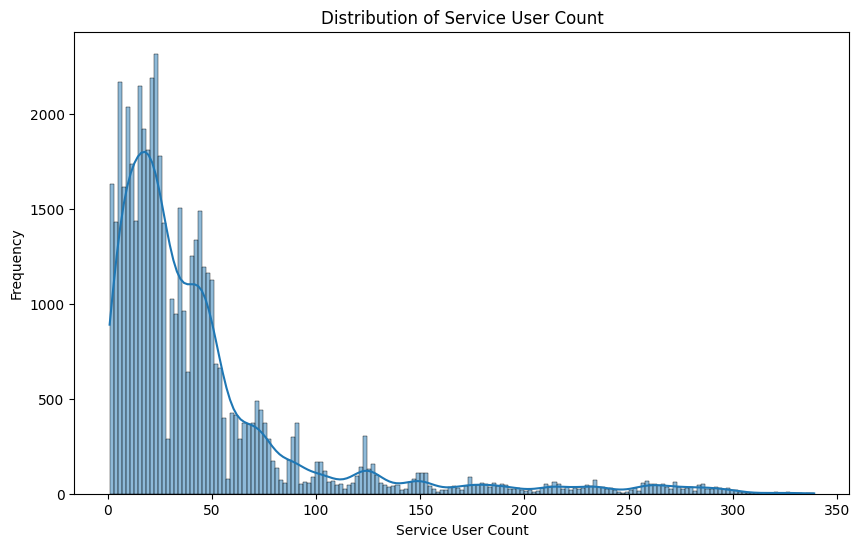

<ipython-input-73-1313a1569463>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trtHomeless_filtered_dropna['OCCUPANCY_RATE_BEDS'] = trtHomeless_filtered_dropna['OCCUPIED_BEDS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_BED']
<ipython-input-73-1313a1569463>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trtHomeless_filtered_dropna['OCCUPANCY_RATE_ROOMS'] = trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM']


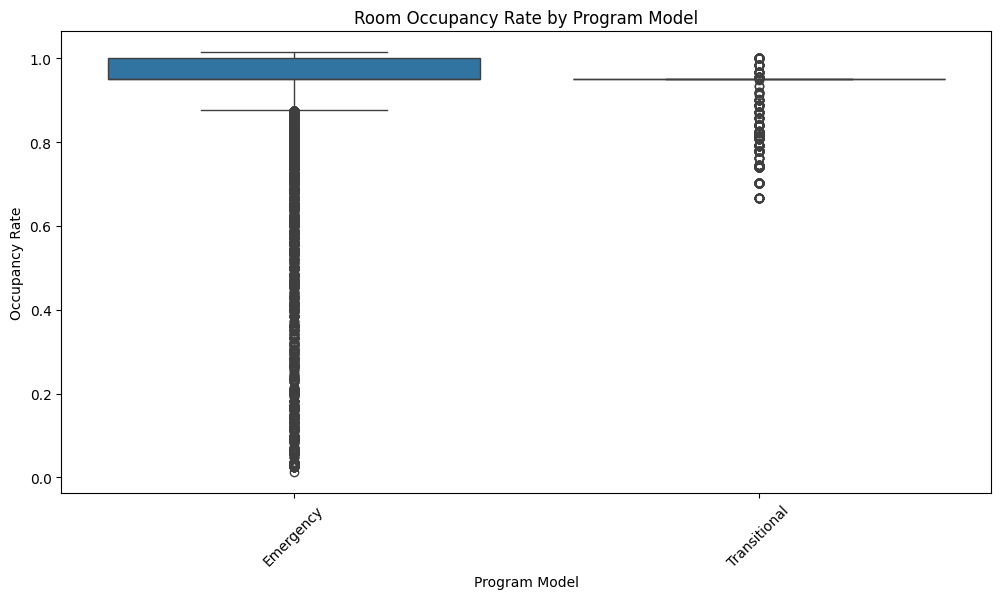

In [73]:
# Step3: Perform exploratory data analysis using a package.

# Quick overview of basic statistics
print(trtHomeless_filtered_dropna.describe())

# Distribution of SERVICE_USER_COUNT
plt.figure(figsize=(10, 6))
sns.histplot(trtHomeless_filtered_dropna['SERVICE_USER_COUNT'], kde=True)
plt.title('Distribution of Service User Count')
plt.xlabel('Service User Count')
plt.ylabel('Frequency')
plt.show()

# Calculate occupancy rates
trtHomeless_filtered_dropna['OCCUPANCY_RATE_BEDS'] = trtHomeless_filtered_dropna['OCCUPIED_BEDS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_BED']
trtHomeless_filtered_dropna['OCCUPANCY_RATE_ROOMS'] = trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM']

# Boxplot to compare occupancy rates between program models
plt.figure(figsize=(12, 6))
sns.boxplot(x='PROGRAM_MODEL', y='OCCUPANCY_RATE_ROOMS', data=trtHomeless_filtered_dropna)
plt.title('Room Occupancy Rate by Program Model')
plt.xlabel('Program Model')
plt.ylabel('Occupancy Rate')
plt.xticks(rotation=45)
plt.show()


This preliminary EDA provides information on shelter occupancy and use, setting the stage for a more thorough investigation. These results could be expanded upon in future studies to examine how shelter programs affect the number of homeless people, evaluate capacity planning, and influence policy choices.

<ipython-input-77-0a8cf87dd7e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trtHomeless_filtered_dropna['BED_OCCUPANCY_RATE'] = trtHomeless_filtered_dropna['OCCUPIED_BEDS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_BED']
<ipython-input-77-0a8cf87dd7e5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trtHomeless_filtered_dropna['ROOM_OCCUPANCY_RATE'] = trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM']


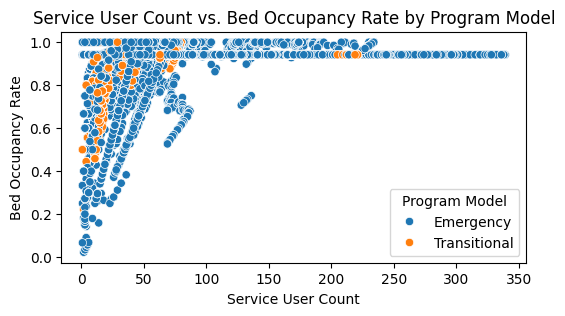

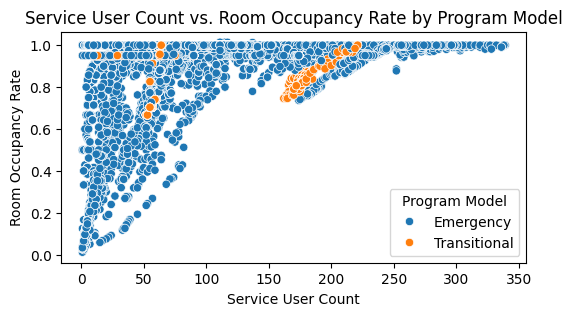

In [77]:
# Step3: Perform exploratory data analysis using a package.
# Topic: Find relationship between the SERVICE_USER_COUNT and occupancy rates (for both beds and rooms)

# Calculate occupancy rates
trtHomeless_filtered_dropna['BED_OCCUPANCY_RATE'] = trtHomeless_filtered_dropna['OCCUPIED_BEDS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_BED']
trtHomeless_filtered_dropna['ROOM_OCCUPANCY_RATE'] = trtHomeless_filtered_dropna['OCCUPIED_ROOMS'] / trtHomeless_filtered_dropna['CAPACITY_ACTUAL_ROOM']

# Scatter plot for Service User Count vs. Bed Occupancy Rate
plt.figure(figsize=(6, 3))
sns.scatterplot(x='SERVICE_USER_COUNT', y='BED_OCCUPANCY_RATE', hue='PROGRAM_MODEL', data=trtHomeless_filtered_dropna)
plt.title('Service User Count vs. Bed Occupancy Rate by Program Model')
plt.xlabel('Service User Count')
plt.ylabel('Bed Occupancy Rate')
plt.legend(title='Program Model')
plt.show()

# Scatter plot for Service User Count vs. Room Occupancy Rate
plt.figure(figsize=(6, 3))
sns.scatterplot(x='SERVICE_USER_COUNT', y='ROOM_OCCUPANCY_RATE', hue='PROGRAM_MODEL', data=trtHomeless_filtered_dropna)
plt.title('Service User Count vs. Room Occupancy Rate by Program Model')
plt.xlabel('Service User Count')
plt.ylabel('Room Occupancy Rate')
plt.legend(title='Program Model')
plt.show()

These scatter plots can help us identify if there's a correlation between the number of service users and occupancy rates, and how this relationship might differ across program models.

In the first plot, we observe a dispersion of points that indicates the relationship between the number of service users and the bed occupancy rate. The data points are color-coded to distinguish between Emergency (blue) and Transitional (orange) program models. There seems to be a concentration of data points at lower service user counts for both program models, indicating that a majority of the data has lower service user counts and varied bed occupancy rates. For higher service user counts, the bed occupancy rate tends to cluster closer to 1.0, especially for the Emergency model, which might suggest that when service user counts increase, Emergency shelters tend to reach full bed capacity.

The second plot shows a similar comparison but for room occupancy rates. Again, there's a significant concentration of data points at lower service user counts, with room occupancy rates spread across the range for both program models. As service user counts increase, the room occupancy rate for Emergency shelters shows a trend towards higher occupancy, almost reaching a rate of 1.0, implying that higher demand in service users correlates with higher room utilization. In contrast, the Transitional program model seems to show a slightly less dense clustering towards full occupancy, suggesting they may not reach full room capacity as consistently as Emergency shelters do at higher service user counts.

Further analysis might focus on understanding the drivers behind the full occupancy rates for Emergency shelters and the factors leading to the variability in Transitional shelters. Additionally, examining other variables not depicted in these plots could provide a more comprehensive view of shelter usage patterns and capacity needs.